# Wasserstein distance and the difference in life expectancy

## Short description of the Wasserstein distance

The Wasserstein distance (or earth mover's distance) computes the minimum "work" needed to transform one distribution into the other and refers to *optimal transport theory*.
According to [https://docs.scipy.org](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html), the Wasserstein distance "is a similarity metric between two probability distributions. In the discrete case, the Wasserstein distance can be understood as the cost of an optimal transport plan to convert one distribution into the other. The cost is calculated as the product of the amount of probability mass being moved and the distance it is being moved."

In the one-dimensional case and when the cost function is defined as $c(x,y)=|x-y|$, the Wasserstein distance can be expressed as,
$$
W(u,v)=\int_{-\infty}^{\infty}|U-V|,
$$
where $U$ and $V$ are the respective cumulative distribution functions (CDF) of $u$ and $v$.
See Santambrogio (2015), chapter 2 for more details [Santambrogio (2015)](https://link.springer.com/book/10.1007/978-3-319-20828-2).

## Short description of life expectancy at birth

In demography, life expectancy at birth ($e_0$) measures the expected number of life years on the basis of a set of age-specific mortality rates. $e_0$ is derived from a period life table - a procedure where age-specific mortality rates are applied to hypothetical cohort to calculate the number of persons alive and deceased in each age interval. This table will then be used to derive the expected number of life years. Usually, the size of the initial life table population is set to 100 000 persons. The number of deceased persons in each age interval is denoted as $d_x$, while $l_x$ gives the age-specific number of persons alive. When setting the initial size of the life table population to $1$, the $d_x$ function can be seen as a probability density function (PDF). $e_0$ is the mean age at death,
$$
e_0=\frac{\int_0^{\omega}x\cdot d(x)dx}{\int_0^{\omega}d(x)dx},
$$
where $\omega$ denotes the upper age interval.
A more popular formular, however, is expressing $e_0$ as the area under the survivorship curve,
$$
e_0=\int_0^{\omega}l(x)dx.
$$
The difference between two $e_0$ values is then,
$$
e_{0,A}-e_{0,A} = \int_0^{\omega}(l_A(x)-l_B(x))dx
$$
## The relationship between the Wasserstein distance and difference between two life expectancy at birth values

It is well-known in surival analysis that PDF, CDF, and the survivorship function are directly linked to each other. That is, the survivorship function can be derived from the PDF and is complement of the CDF,
$$
S(x)=1-\int_{-\infty}^x f(u)du\\
=1-F(x).
$$

As shown above, the Wasserstein distance is the area between two CDFs. Substituting the CDFs with the life table survivorship function $l_x$ gives,
$$
W(d_A,d_B)=\int_{0}^{\omega}|l_A(x)-l_B(x)|dx.
$$
This implies that the difference between two $e_0$ values is equal to the Wasserstein distance between two life table age-at-death distributions, whenever $l_A(x) >= l_B(x)$ for all $x$.

## Demonstration in Python using life tables from the Human Mortality Database

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Data availability

Data can be downloaded from [www.mortality.org](www.mortality.org).

In [7]:
USA = pd.read_csv("bltper_1x1_US.txt", sep="\s+", skiprows=2)
Germany = pd.read_csv("bltper_1x1_Germany.txt", sep="\s+", skiprows=2)

# Functions

Please note that I use "lx" and "Sx" interchangeable for denoting the survivorship function.

In [13]:
def get_dx(df, year):
    qx = df.loc[df["Year"] == year, "qx"].values
    lx = np.concatenate(([1], np.cumprod(1 - qx)[:-1]))
    dx = np.concatenate((-np.diff(lx), [lx[-1]]))
    return dx

def get_e0(df, year):
    ex = df.loc[df["Year"] == year, "ex"].values
    e0 = ex[0]
    return e0

def plot_dx(ages, dx1, dx2, e0_1, e0_2, label1, label2):
    plt.figure(figsize=(10, 6))
    plt.plot(ages, dx1, label=f"{label1} (e₀ = {e0_1:.1f})", marker='o')
    plt.plot(ages, dx2, label=f"{label2} (e₀ = {e0_2:.1f})", marker='s')
    plt.text(ages[np.argmax(dx1)]-10, max(dx1), f"e₀ = {e0_1:.1f}", fontsize=10, ha='left', va='bottom')
    plt.text(ages[np.argmax(dx2)]-10, max(dx2), f"e₀ = {e0_2:.1f}", fontsize=10, ha='left', va='bottom')
    plt.title("Comparison of Death Distributions by Age")
    plt.xlabel("Age")
    plt.ylabel("dx (number of deaths)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_Sx(ages, Sx1, Sx2, label1, label2):
    plt.figure(figsize=(10, 6))
    plt.plot(ages, Sx1, label=f"{label1}", marker='o')
    plt.plot(ages, Sx2, label=f"{label2}", marker='s')
    plt.fill_between(ages, Sx1, Sx2, color='gray', alpha=0.4)
    plt.title("Comparison of survivorship functions")
    plt.xlabel("Age")
    plt.ylabel("Proportion of being alive")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_Sx(dx):
    CDF = np.cumsum(dx)
    Sx = 1 - CDF
    return Sx

def get_Wasserstein(dx1, dx2):
    CDF1 = np.cumsum(dx1)
    Sx1 = 1 - CDF1
    CDF2 = np.cumsum(dx2)
    Sx2 = 1 - CDF2
    Sx_diff_absolute = abs(Sx1 - Sx2)
    Wasserstein = round(np.sum(Sx_diff_absolute), 2)
    return Wasserstein  

# Calculations

The first example demonstrates the case where the Wasserstein distance correponds to the difference in $e_0$, while the second one shows that the difference in $e_0$ can be very small even though the age-at-death distributions differ substantially from each other. This is captured by the Wasserstein distance correctly.

In [10]:
dx_1980_US = get_dx(USA, 1980)
dx_1990_US = get_dx(USA, 1990)
dx_2019_US = get_dx(USA, 2019)

ages = np.arange(len(dx_1980_US))

dx_1990_Germany = get_dx(Germany, 1990)

e0_1980_US = get_e0(USA, 1980)
e0_1990_US = get_e0(USA, 1990)
e0_2019_US = get_e0(USA, 2019)
e0_1990_Germany = get_e0(Germany, 1990)

Sx_1980_US = get_Sx(dx_1980_US)
Sx_1990_US = get_Sx(dx_1990_US)
Sx_2019_US = get_Sx(dx_2019_US)
Sx_1990_Germany = get_Sx(dx_1990_Germany)


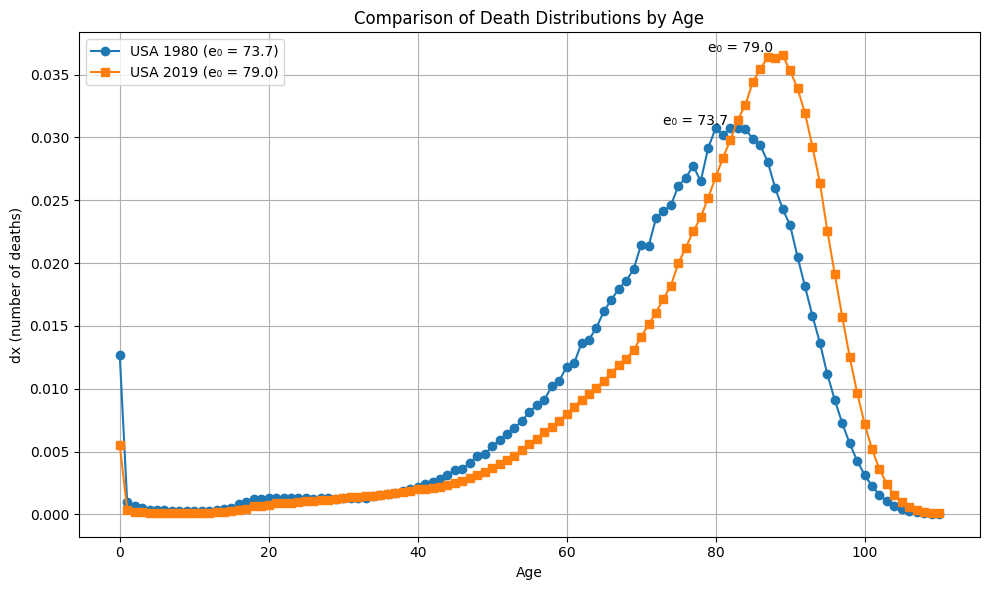

In [112]:
plot_dx(ages, dx_1980_US, dx_2019_US, e0_1980_US, e0_2019_US, "USA 1980", "USA 2019")


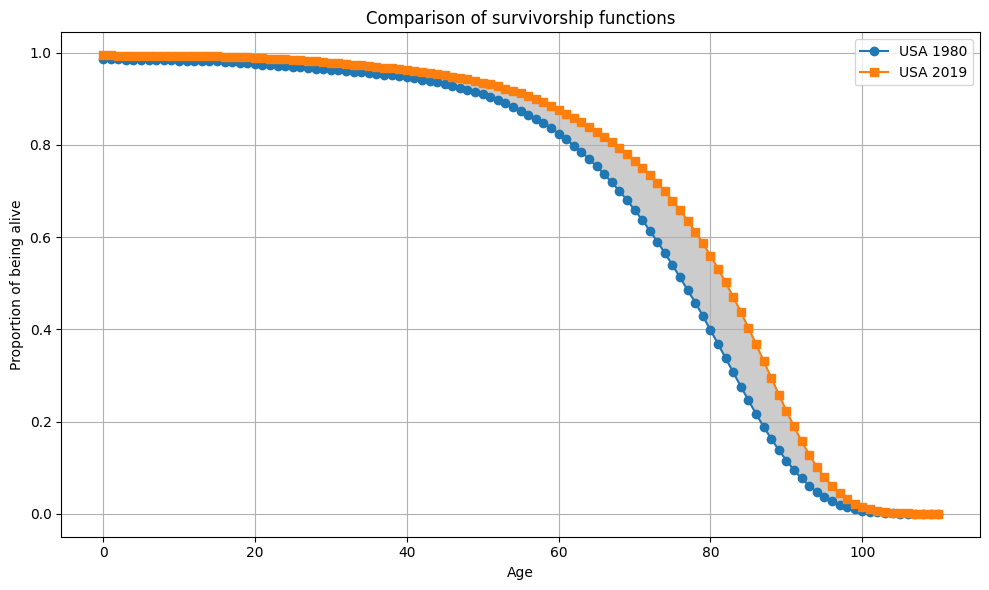

In [113]:
plot_Sx(ages, Sx_1980_US, Sx_2019_US, "USA 1980", "USA 2019")

In [114]:
condition = np.all(Sx_2019_US >= Sx_1980_US)
if condition:
    print("Sx1 >= Sx2 for all x")
else:
    print("Sx1 not always >= Sx2 for all x")



Difference_in_e0_US_2019_and_US_1980 = round(e0_2019_US - e0_1980_US, 2)
Wasserstein_between_2019_US_1980_US = get_Wasserstein(dx_2019_US, dx_1980_US)

print(f"The difference in e0 is: {Difference_in_e0_US_2019_and_US_1980}")
print(f"The Wasserstein distance is: {Wasserstein_between_2019_US_1980_US}")


Sx1 >= Sx2 for all x
The difference in e0 is: 5.21
The Wasserstein distance is: 5.21


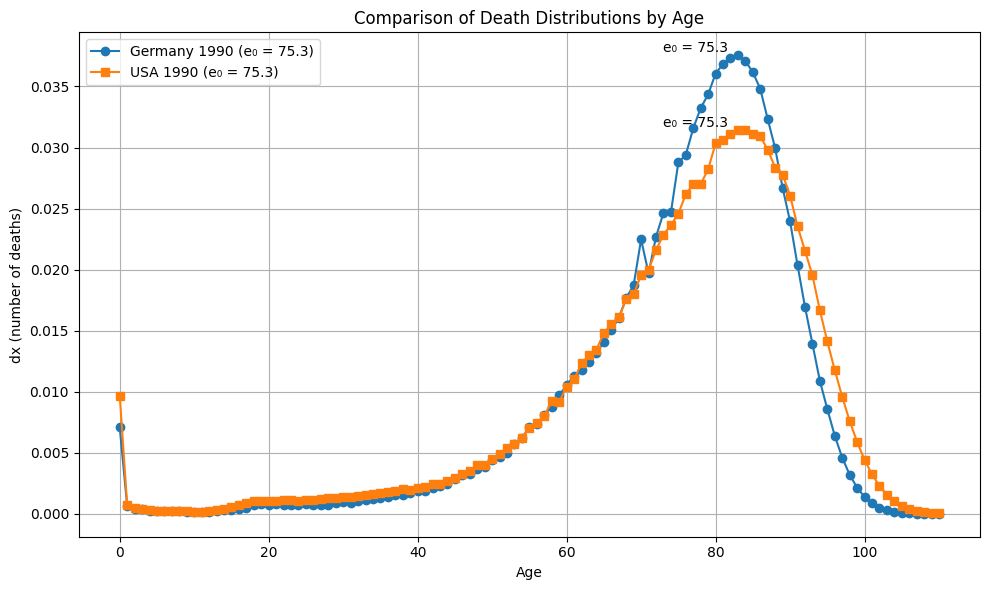

In [115]:
plot_dx(ages, dx_1990_Germany, dx_1990_US, e0_1990_Germany, e0_1990_Germany, "Germany 1990", "USA 1990")

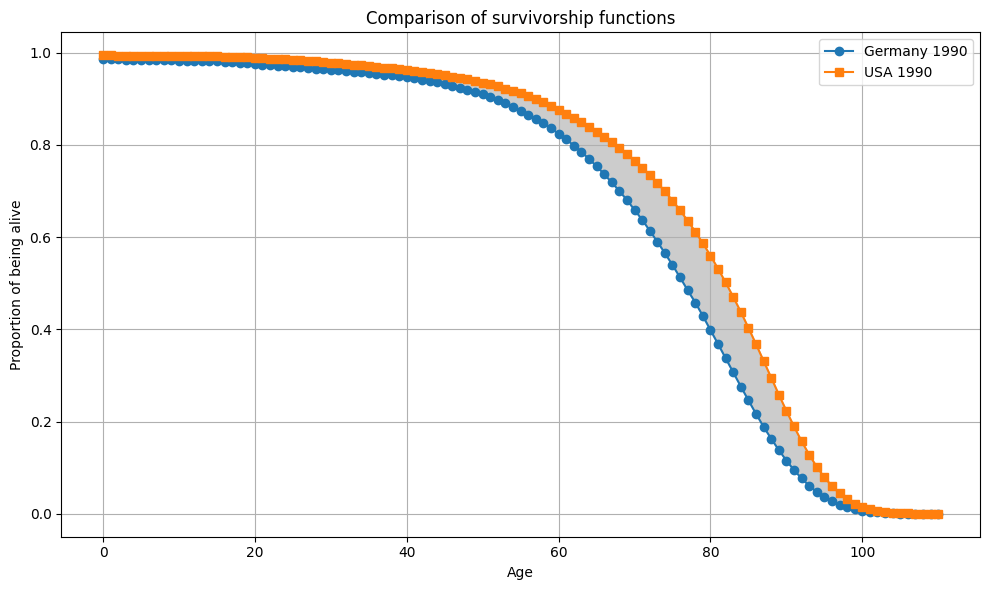

In [116]:
plot_Sx(ages, Sx_1980_US, Sx_2019_US, "Germany 1990", "USA 1990")

In [117]:
condition = np.all(Sx_1990_Germany >= Sx_1990_US)
if condition:
    print("Sx1 >= Sx2 for all x")
else:
    print("Sx1 not always >= Sx2 for all x")

Difference_in_e0_Germany_1990_and_US_1990 = round(e0_1990_Germany - e0_1990_US, 2)
Wasserstein_between_Germany_1990_US_1990_US = get_Wasserstein(dx_1990_Germany, dx_1990_US)

print(f"The difference in e0 is: {Difference_in_e0_Germany_1990_and_US_1990}")
print(f"The Wasserstein distance is: {Wasserstein_between_Germany_1990_US_1990_US}")

Sx1 not always >= Sx2 for all x
The difference in e0 is: -0.05
The Wasserstein distance is: 1.56


# Conclusion

When the survivorship functions between two populations do not crossover, the Wasserstein distance is equal to the difference in $e_0$. Hence, we do not compare the means of two age-at death distibutions anymore - as usually when comparing two $e_0$ values - but we solve the optimal transport problem. This offers a novel interpretation. There are also cases where the two measures do not correspond to each other. The difference in $e_0$ can suggest rather small mortality differences between two populations. The Wasserstein distance captures those differences between the two age-at death distributions better. Since the Wasserstein distance can be derived easily it makes sense to calculate both measures.

In [4]:
!pip install pot

  Obtaining dependency information for pot from https://files.pythonhosted.org/packages/6e/95/14902c778117ad9ac7af62dd1d951942440c57df991d7f937f416ee6320f/POT-0.9.5-cp312-cp312-win_amd64.whl.metadata
   ---------------------------------------- 0.0/347.9 kB ? eta -:--:--
   -------- ------------------------------- 71.7/347.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 347.9/347.9 kB 5.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Users\Markus\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import ot  # pip install POT

# Example setup
ages = np.arange(0, 101)   # ages 0-100
n_ages = len(ages)
n_causes = 4

# Joint distributions: shape (n_ages * n_causes,)
# Example: A puts more mass on cause 1 and younger deaths
dA = np.zeros((n_ages, n_causes))
dB = np.zeros((n_ages, n_causes))

# Fill distributions (toy example)
dA[30,0] = 0.2   # 20% die at age 30, cause 1
dA[70,1] = 0.3   # 30% die at age 70, cause 2
dA[80,2] = 0.5   # 50% die at age 80, cause 3

dB[32,0] = 0.2
dB[72,1] = 0.3
dB[85,2] = 0.5

# Flatten into vectors
a = dA.flatten()
b = dB.flatten()

# Ensure they sum to 1
a /= a.sum()
b /= b.sum()

# Build cost matrix
# Each state is (age, cause), so size = (n_ages*n_causes, n_ages*n_causes)
X = []
for age in ages:
    for cause in range(n_causes):
        X.append((age, cause))
X = np.array(X)

M = np.zeros((len(X), len(X)))
for i, (age_i, cause_i) in enumerate(X):
    for j, (age_j, cause_j) in enumerate(X):
        age_cost = abs(age_i - age_j)
        cause_cost = 0 if cause_i == cause_j else 1  # tweak this!
        M[i,j] = age_cost + cause_cost

# Compute Wasserstein distance
W1 = ot.emd2(a, b, M)  # squared cost
print("Wasserstein distance:", W1)


Wasserstein distance: 3.5


In [14]:
import numpy as np
from scipy.stats import wasserstein_distance

# -----------------------------
# Step 1: Example age-at-death distributions (all-cause)
# -----------------------------
ages = np.arange(0, 101)  # ages 0-100
# Distribution A: more deaths younger
dA = np.exp(-((ages - 60) ** 2) / (2 * 10**2))
dA /= dA.sum()  # normalize to 1

# Distribution B: shifted to older ages
dB = np.exp(-((ages - 70) ** 2) / (2 * 10**2))
dB /= dB.sum()


SA = get_Sx(dA)
SB = get_Sx(dB)
W1 = np.sum(abs(SA-SB))

# -----------------------------
# Step 2: Wasserstein distance for all-cause mortality
# -----------------------------
W_all = wasserstein_distance(ages, ages, dA, dB)
print("All-cause Wasserstein distance (W1):", W_all)
print("All-cause Wasserstein distance (W1) CDF:", W1)



All-cause Wasserstein distance (W1): 9.963078033679697
All-cause Wasserstein distance (W1) CDF: 9.963078033679706


In [15]:
cause_shares = np.array([
    0.25 * np.ones_like(ages),       # cause 1
    0.25 * np.exp(-ages/100),        # cause 2 more common at younger ages
    0.25 * np.exp(-(100-ages)/100),  # cause 3 more common at older ages
    0.25 * np.ones_like(ages)        # cause 4 uniform
])
cause_shares /= cause_shares.sum(axis=0)  # normalize so shares sum to 1 at each age

# Allocate deaths by cause
dA_causes = dA[:, None] * cause_shares.T   # shape (ages, causes)
dB_causes = dB[:, None] * cause_shares.T

# -----------------------------
# Step 4: Wasserstein distances by cause
# -----------------------------
W_causes = []
for c in range(4):
    da = dA_causes[:, c]
    db = dB_causes[:, c]
    Wc = wasserstein_distance(ages, ages, da, db)
    W_causes.append(Wc)
    print(f"Cause {c+1} Wasserstein distance: {Wc:.3f}")

# Aggregate across causes (weighted sum by exposure = total prob mass per cause)
total_W = sum(W_causes)
print("Sum of cause-specific Wasserstein distances:", total_W)

Cause 1 Wasserstein distance: 9.927
Cause 2 Wasserstein distance: 9.936
Cause 3 Wasserstein distance: 9.915
Cause 4 Wasserstein distance: 9.927
Sum of cause-specific Wasserstein distances: 39.70540196009073


In [20]:
# Example: all-cause and cause-specific Wasserstein (full-joint and within-cause)
import numpy as np
from scipy.stats import wasserstein_distance
import ot  # pip install POT

# ---------- toy all-cause distributions (1D ages) ----------
ages = np.arange(0, 101)  # 0..100
n_ages = ages.size
n_causes = 4

# Two all-cause age distributions (normalized)
dA = np.exp(-((ages - 60) ** 2) / (2 * 10**2))
dA = dA / dA.sum()
dB = np.exp(-((ages - 70) ** 2) / (2 * 10**2))
dB = dB / dB.sum()

# All-cause W1 (1D closed form)
W_all = wasserstein_distance(ages, ages, dA, dB)
print("All-cause W1 (1D CDF method):", W_all)

# ---------- split into causes (create joint distributions) ----------
# Here we create cause-shares that are identical across A and B for simplicity
cause_shares = np.vstack([
    0.25 * np.ones(n_ages),               # cause 0
    0.25 * np.exp(-ages / 100.0),         # cause 1: younger skew
    0.25 * np.exp(-(100 - ages) / 100.0), # cause 2: older skew
    0.25 * np.ones(n_ages)                # cause 3
])  # shape (4, n_ages)
# normalize columns so shares sum to 1 at each age
cause_shares = cause_shares / cause_shares.sum(axis=0, keepdims=True)

# Form joint dA_joint(age, cause) and dB_joint
dA_joint = (dA[:, None] * cause_shares.T)  # shape (n_ages, n_causes)
dB_joint = (dB[:, None] * cause_shares.T)

# Flatten to vectors over grid (age major, cause minor)
a = dA_joint.flatten()  # length n_ages*n_causes
b = dB_joint.flatten()

# Sanity: distributions sum to 1
print("sum(a), sum(b) =", a.sum(), b.sum())

# ---------- Build cost matrix for full joint OT ----------
# grid points: (age, cause)
grid = [(age, cause) for age in ages for cause in range(n_causes)]
# build M with cause penalty lambda
lam = 2
N = len(grid)
M_penalty = np.zeros((N, N))
for i, (age_i, cause_i) in enumerate(grid):
    for j, (age_j, cause_j) in enumerate(grid):
        age_cost = abs(age_i - age_j)
        cause_cost = lam if (cause_i != cause_j) else 0.0
        M_penalty[i, j] = age_cost + cause_cost

W_with_penalty = ot.emd2(a, b, M_penalty)
print("Full 2D W1 with cause-penalty (lambda=1):", W_with_penalty)

All-cause W1 (1D CDF method): 9.963078033679697
sum(a), sum(b) = 1.0000000000000002 0.9999999999999999
Full 2D W1 with cause-penalty (lambda=1): 10.004064070611873


In [21]:
import numpy as np
import ot
from scipy.stats import wasserstein_distance

# toy setup (if you already have data, skip to cost-building)
ages = np.arange(0, 101)   # 0..100
n_ages = len(ages)
n_causes = 4

# toy age marginals
dA = np.exp(-((ages - 60) ** 2) / (2 * 10**2)); dA /= dA.sum()
dB = np.exp(-((ages - 70) ** 2) / (2 * 10**2)); dB /= dB.sum()

# cause shares identical for both (toy)
cause_shares = np.vstack([
    0.25 * np.ones(n_ages),
    0.25 * np.exp(-ages / 100.0),
    0.25 * np.exp(-(100 - ages) / 100.0),
    0.25 * np.ones(n_ages)
])
cause_shares = cause_shares / cause_shares.sum(axis=0, keepdims=True)

dA_joint = (dA[:, None] * cause_shares.T)   # shape (n_ages, n_causes)
dB_joint = (dB[:, None] * cause_shares.T)
a = dA_joint.flatten()
b = dB_joint.flatten()
grid = [(age, c) for age in ages for c in range(n_causes)]
N = len(grid)

# ---------- Option A: normalize ages to [0,1], set lambda=1 ----------
max_age = ages.max()
M_A = np.zeros((N, N), dtype=float)
lambda_A = 1.0
for i, (age_i, cause_i) in enumerate(grid):
    for j, (age_j, cause_j) in enumerate(grid):
        age_cost = abs(age_i/max_age - age_j/max_age)   # scaled age in [0,1]
        cause_cost = lambda_A if (cause_i != cause_j) else 0.0
        M_A[i, j] = age_cost + cause_cost

W_optionA = ot.emd2(a, b, M_A)
print("W (Option A, ages scaled to [0,1], lambda=1):", W_optionA)

# ---------- Option B: keep ages in years, set lambda = typical age cost ----------
# example: use all-cause W1 as typical age-scale
W_all = wasserstein_distance(ages, ages, dA, dB)
lambda_B = W_all  # now a cause-jump costs about the same as the overall W1 age shift
M_B = np.zeros((N, N), dtype=float)
for i, (age_i, cause_i) in enumerate(grid):
    for j, (age_j, cause_j) in enumerate(grid):
        age_cost = abs(age_i - age_j)   # in years
        cause_cost = lambda_B if (cause_i != cause_j) else 0.0
        M_B[i, j] = age_cost + cause_cost

W_optionB = ot.emd2(a, b, M_B)
print("W (Option B, ages in years, lambda = all-cause W1):", W_optionB)

# For comparison, the all-cause 1D W1:
W_all_1d = W_all
print("All-cause W1 (1D):", W_all_1d)


W (Option A, ages scaled to [0,1], lambda=1): 0.12012379880288185
W (Option B, ages in years, lambda = all-cause W1): 10.167251575802938
All-cause W1 (1D): 9.963078033679697


In [23]:
import numpy as np
from scipy.stats import wasserstein_distance
import ot  # pip install POT

# -----------------------------
# 1) Abridged age groups and normalized support in [0,1]
# -----------------------------
age_bounds = [0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]  # lower bounds
age_labels = ["0", "1-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34",
              "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69",
              "70-74", "75-79", "80-84", "85+"]

# Midpoints (approximate 85+ by 90 just to fix a finite representative point)
midpoints = np.array([0.5, 3.0, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5,
                      42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5, 90.0])
x = midpoints
# Normalize ages to [0,1]
x_min, x_max = x.min(), x.max()
x01 = (x - x_min) / (x_max - x_min)

n_age = len(x01)
n_cause = 4

# -----------------------------
# 2) All-cause age-at-death distributions dA, dB (sum to 1)
# -----------------------------
# Two different shapes (toy example: shifted logit-like weights)
dA = np.exp(-((x - 72)**2) / (2 * 14**2))
dB = np.exp(-((x - 63)**2) / (2 * 14**2))
dA = dA / dA.sum()
dB = dB / dB.sum()
print("All-cause sums:", dA.sum(), dB.sum())

# -----------------------------
# 3) All-cause W1 two ways: SciPy vs. CDF integral (they should match)
# -----------------------------
# (a) SciPy on normalized support
W1_all_scipy = wasserstein_distance(x01, x01, dA, dB)

# (b) CDF integral on normalized support:
#     For discrete support {x1<...<xn}, ∫|FA-FB| dx = Σ_{k=1}^{n-1} |CumA_k - CumB_k| * (x_{k+1}-x_k),
#     where Cum*_k are right-continuous CDFs after including mass at x_k.
order = np.argsort(x01)
x01_sorted = x01[order]
a_sorted = dA[order]
b_sorted = dB[order]
cdfA_right = np.cumsum(a_sorted)
cdfB_right = np.cumsum(b_sorted)
widths = np.diff(x01_sorted)  # gaps on [0,1]
W1_all_cdf = np.sum(np.abs(cdfA_right[:-1] - cdfB_right[:-1]) * widths)

print("All-cause W1 (SciPy, ages in [0,1]):", W1_all_scipy)
print("All-cause W1 (CDF integral, ages in [0,1]):", W1_all_cdf)

All-cause sums: 1.0 1.0
All-cause W1 (SciPy, ages in [0,1]): 0.08068067094480705
All-cause W1 (CDF integral, ages in [0,1]): 0.08068067094480709


In [34]:
# -----------------------------
# 4) Cause-specific splits (make A and B different to trigger cause penalties)
# -----------------------------
rng = np.random.default_rng(123)

# Cause shares by age for A: smoother profile
sharesA = np.vstack([
    0.35 * np.exp(-x01 / 0.4) + 0.05,           # cause 1: more at young
    0.25 * (1 - np.abs(x01 - 0.5) / 0.5) + 0.05,# cause 2: middle ages
    0.25 * np.exp(-(1 - x01) / 0.4) + 0.05,     # cause 3: older ages
    0.10 * np.ones_like(x01) + 0.05             # cause 4: flat baseline
]).T  # shape (n_age, n_cause)

# Cause shares by age for B: shift weights to different causes
sharesB = np.vstack([
    0.20 * np.exp(-x01 / 0.4) + 0.10,
    0.30 * (1 - np.abs(x01 - 0.4) / 0.5) + 0.05,
    0.35 * np.exp(-(1 - x01) / 0.35) + 0.05,
    0.10 * np.ones_like(x01) + 0.05
]).T

# Normalize shares row-wise to sum to 1 at each age
sharesA = sharesA / sharesA.sum(axis=1, keepdims=True)
sharesB = sharesB / sharesB.sum(axis=1, keepdims=True)

# Joint distributions over (age, cause); each sums to 1
dA_joint = dA[:, None] * sharesA
dB_joint = dB[:, None] * sharesB
print("Joint sums:", dA_joint.sum(), dB_joint.sum())

# Flatten for OT
a = dA_joint.ravel()
b = dB_joint.ravel()

# Fix floating point drift: clip small negatives, renormalize to 1
a = np.clip(a, 0, None)
b = np.clip(b, 0, None)
a = a / a.sum()
b = b / b.sum()

print("Sum a, b:", a.sum(), b.sum())  # should be exactly 1.0

# -----------------------------
# 5) 2D cost with lambda=1 on ages in [0,1]
#     c((x,c),(y,c')) = |x-y| + 1{c!=c'}
# -----------------------------
grid = [(age01, cause) for age01 in x01 for cause in range(n_cause)]
N = len(grid)
lam = 0.2

M = np.zeros((N, N), dtype=float)
for i, (xi, ci) in enumerate(grid):
    for j, (xj, cj) in enumerate(grid):
        age_cost = abs(xi - xj)          # in [0,1]
        cause_cost = lam if (ci != cj) else 0.0
        M[i, j] = age_cost + cause_cost

# 2D Wasserstein with cause penalty
W1_2D_lambda1 = ot.emd2(a, b, M)

W1_2D_lambda1 = ot.emd2(a, b, M)
print("Cause-specific 2D W1 (ages in [0,1], lambda=1):", W1_2D_lambda1)

Joint sums: 1.0 1.0
Sum a, b: 1.0 0.9999999999999999
Cause-specific 2D W1 (ages in [0,1], lambda=1): 0.08812935914226754


In [31]:
print(ot.emd2(a, b, M))

0.0


c:\Python\Wasserstein\.venv\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


In [1]:
import numpy as np
from scipy.stats import wasserstein_distance
import ot  # pip install POT

# Toy example (same as before)
ages = np.array([10.0, 70.0])
grid = [(10.0,1),(10.0,2),(70.0,1),(70.0,2)]
a = np.array([0.8,0.0,0.0,0.2])
b = np.array([0.0,0.2,0.8,0.0])

# Age marginals and 1D W1
a_age = np.array([a[0]+a[1], a[2]+a[3]])
b_age = np.array([b[0]+b[1], b[2]+b[3]])
W1_1d = wasserstein_distance(ages, ages, a_age, b_age)
print("All-cause W1 (1D):", W1_1d)

# Build cost matrix with lambda = 1
lam = 1.0
N = len(a)
M = np.zeros((N, N))
for i,(xi,ci) in enumerate(grid):
    for j,(xj,cj) in enumerate(grid):
        M[i,j] = abs(xi-xj) + (lam if ci!=cj else 0.0)

# Normalize marginals (should already sum to 1)
a_vec = a / a.sum()
b_vec = b / b.sum()

# Compute OT with POT
W_ot = ot.emd2(a_vec, b_vec, M)  # returns total transport cost
print("POT ot.emd2 result:", W_ot)


All-cause W1 (1D): 36.00000000000001
POT ot.emd2 result: 36.40000000000001


In [2]:
# Paste this block into your Python script / notebook.

import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.optimize import linprog

def midpoint_from_label(label):
    s = str(label).strip()
    if '+' in s:
        base = int(s.replace('+',''))
        return base + 2.5
    if '-' in s:
        lo, hi = s.split('-')
        return (float(lo) + float(hi)) / 2.0
    try:
        return float(s)
    except:
        raise ValueError(f"Unrecognized age label: {label}")

def solve_ot_lp(a, b, M):
    a = np.asarray(a, dtype=float).copy()
    b = np.asarray(b, dtype=float).copy()
    a[a < 0] = 0.0
    b[b < 0] = 0.0
    a = a / a.sum()
    b = b / b.sum()
    N = len(a)
    c = M.flatten()
    A_eq = np.zeros((2*N, N*N), dtype=float)
    rhs = np.zeros(2*N, dtype=float)
    for i in range(N):
        for j in range(N):
            A_eq[i, i*N + j] = 1.0
        rhs[i] = a[i]
    for j in range(N):
        for i in range(N):
            A_eq[N + j, i*N + j] = 1.0
        rhs[N + j] = b[j]
    bounds = [(0.0, None)] * (N*N)
    res = linprog(c, A_eq=A_eq, b_eq=rhs, bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP failed: " + res.message)
    gamma = res.x.reshape((N, N))
    total_cost = float(np.sum(gamma * M))
    return total_cost, gamma

def compute_wasserstein_from_dfs(dfA, dfB, lambda_cause=None, verbose=False):
    # Validate inputs
    for df in (dfA, dfB):
        if not {'age','cause','deaths'}.issubset(df.columns):
            raise ValueError("DataFrames must contain columns: 'age','cause','deaths'")
    # ages (sorted by numeric midpoint)
    ages_labels = sorted(set(dfA['age'].unique()).union(dfB['age'].unique()), key=lambda x: midpoint_from_label(x))
    midpoints = np.array([midpoint_from_label(lab) for lab in ages_labels], dtype=float)
    age2idx = {lab:i for i,lab in enumerate(ages_labels)}
    causes = sorted(set(dfA['cause'].unique()).union(dfB['cause'].unique()))
    cause2idx = {c:i for i,c in enumerate(causes)}
    n_age = len(ages_labels); n_cause = len(causes)
    def build_joint(df):
        arr = np.zeros((n_age, n_cause), dtype=float)
        for _, row in df.iterrows():
            i = age2idx[row['age']]; j = cause2idx[row['cause']]
            arr[i,j] += float(row['deaths'])
        return arr
    dA_joint = build_joint(dfA); dB_joint = build_joint(dfB)
    totalA = dA_joint.sum(); totalB = dB_joint.sum()
    if totalA <= 0 or totalB <= 0:
        raise ValueError("Total deaths must be positive in each dataframe")
    dA_joint = dA_joint / totalA; dB_joint = dB_joint / totalB
    dA_age = dA_joint.sum(axis=1); dB_age = dB_joint.sum(axis=1)
    # all-cause W1 via scipy
    W_all_scipy = float(wasserstein_distance(midpoints, midpoints, dA_age, dB_age))
    # all-cause W1 via CDF integral (discrete)
    order = np.argsort(midpoints)
    x_sorted = midpoints[order]
    a_sorted = dA_age[order]; b_sorted = dB_age[order]
    cdfA = np.cumsum(a_sorted); cdfB = np.cumsum(b_sorted)
    widths = np.diff(x_sorted)
    if len(widths) == 0:
        W_all_cdf = 0.0
    else:
        W_all_cdf = float(np.sum(np.abs(cdfA[:-1] - cdfB[:-1]) * widths))
    if not np.isclose(W_all_scipy, W_all_cdf, rtol=1e-8, atol=1e-8):
        if verbose:
            print("Warning: all-cause CDF and scipy results differ by", W_all_scipy - W_all_cdf)
    age_gaps = np.diff(np.sort(midpoints))
    if lambda_cause is None:
        lambda_cause = float(np.median(age_gaps)) if len(age_gaps)>0 else 1.0
    a_vec = dA_joint.flatten(); b_vec = dB_joint.flatten()
    a_vec = np.clip(a_vec, 0.0, None); b_vec = np.clip(b_vec, 0.0, None)
    if a_vec.sum() == 0 or b_vec.sum() == 0:
        raise ValueError("After clipping, one distribution has zero mass")
    a_vec = a_vec / a_vec.sum(); b_vec = b_vec / b_vec.sum()
    coords = [(midpoints[i], causes[j]) for i in range(n_age) for j in range(n_cause)]
    N = len(coords)
    M = np.zeros((N, N), dtype=float)
    for i,(xi,ci) in enumerate(coords):
        for j,(xj,cj) in enumerate(coords):
            age_cost = abs(xi - xj)
            cause_cost = lambda_cause if (ci != cj) else 0.0
            M[i,j] = age_cost + cause_cost
    W_joint = None; gamma = None
    try:
        import ot
        av = a_vec.copy(); bv = b_vec.copy()
        av = av / av.sum(); bv = bv / bv.sum()
        W_joint = float(ot.emd2(av, bv, M))
        try:
            gamma = ot.emd(av, bv, M)
        except Exception:
            gamma = None
    except Exception:
        W_joint, gamma = solve_ot_lp(a_vec, b_vec, M)
    return {
        'W_all_cdf': W_all_cdf,
        'W_all_scipy': W_all_scipy,
        'W_joint': W_joint,
        'lambda_cause_used': lambda_cause,
        'midpoints': midpoints,
        'causes': causes,
        'gamma': gamma,
        'dA_age': dA_age,
        'dB_age': dB_age,
        'dA_joint': dA_joint,
        'dB_joint': dB_joint
    }


In [3]:
dta = pd.read_csv("exmaple2.csv", sep=";", decimal=",")
dta.rename(columns={'Age': 'age', 'Cause': 'cause', 'cause_deaths' : 'deaths'}, inplace=True)
AT = dta[dta['Year'] == 1996].drop('Year', axis=1)
CZ = dta[dta['Year'] == 2017].drop('Year', axis=1)
print(AT.head())
print(CZ.head())

   age   cause     deaths
0    0  Cancer  58.038976
1   10  Cancer  60.850589
2   20  Cancer  23.934902
3   25  Cancer  47.022894
4   30  Cancer  41.552812
    age   cause     deaths
80    0  Cancer  20.214174
81   10  Cancer   7.131227
82   20  Cancer   5.872594
83   25  Cancer  15.487060
84   30  Cancer  64.141133


In [5]:
res = compute_wasserstein_from_dfs(AT, CZ, lambda_cause=9.11*4, verbose=True)
print("Demo results:")
print("W_all_cdf:", res['W_all_cdf'])
print("W_all_scipy:", res['W_all_scipy'])
print("W_joint:", res['W_joint'])
print("lambda used:", res['lambda_cause_used'])

Demo results:
W_all_cdf: 9.114810166276992
W_all_scipy: 9.114810166276992
W_joint: 14.59714997720023
lambda used: 36.44


In [ ]:
def get_Sx(dx):
    CDF = np.cumsum(dx)
    Sx = 1 - CDF
    return Sx

def get_Wasserstein(dx1, dx2):
    CDF1 = np.cumsum(dx1)
    Sx1 = 1 - CDF1
    CDF2 = np.cumsum(dx2)
    Sx2 = 1 - CDF2
    Sx_diff_absolute = abs(Sx1 - Sx2)
    Wasserstein = round(np.sum(Sx_diff_absolute), 2)
    return Wasserstein  